In [1]:
import sqlite3
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import lsst.afw.image as afwImage
from lsst.daf.persistence import Butler
from astropy.table import Table
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()
import fakeInjectionPipeline as fip
import data_process_utils as dpu
import os
import glob
import lsst.afw.image as afwImage
from lsst.afw.table import BaseCatalog


In [2]:
config_list = ['al_spatial1', 'al_spatial2', 'al_spatial3', 'al_spatial4',
               'al_spatial1Pca', 'al_spatial2Pca', 'al_spatial3Pca', 'al_spatial4Pca']
patch_list = ['00', '11', '22', '33', '44', '55', '66']
host_mag_list = ['20_21']
fake_mag_list = [20]
injection_db_path = './data/table/gal_4639/injection_coord.sqlite'
calexp_info_dict, injection_coord_dict = fip.get_calexp_injection_dict(
    patch_list, host_mag_list, dbpath=injection_db_path
)

In [8]:
"""
fake_dir = f'./data/patch_0to6/injection'
injector = fip.fakeInjectionPipeline(
    fake_dir = fake_dir, patch_list = patch_list,
    host_mag_list=host_mag_list, fake_mag_list=fake_mag_list,
    calexp_info_dict=calexp_info_dict, injection_coord_dict=injection_coord_dict
)
for cf_type in config_list:
    config = f'./config/diffimConfig_{cf_type}.py'
    file_path = f'./spatial_{cf_type}.sh'
    diff_dir =  f'./data/patch_0to6/spatial_dof/{cf_type}'
    injector.get_subtraction_script(diff_dir , config=config,
                                    file_path=file_path, use_slurm=True)
""";

In [27]:
"""
for cf_type in config_list:
    diff_dir =  f'./data/patch_0to6/spatial_dof/{cf_type}'
    fip.check_exsistance(patch_list, host_mag_list, fake_mag_list, calexp_info_dict, diff_dir)
""";

In [17]:
"""
for cf_type in config_list:
    diff_dir =  f'./data/patch_0to6/spatial_dof/{cf_type}'
    flux_dir = f'./data/patch_0to6/spatial_dof/{cf_type}/detection'
    injector.get_detection(diff_dir=diff_dir, flux_dir=flux_dir,
                           db_name=f'detection.sqlite')
""";

# Analysis

#### get data

In [7]:
# get diffexp and diaSrc table
patch_id = 4
diffexp_path_list = glob.glob('./data/patch_0to6/spatial_dof/al_spatial1'
                              f'/{patch_id}{patch_id}_20_21_*/diff_20/deepDiff/*/*/diffexp*.fits')
key_list = []
diffexp_dict = {}
diaSrc_dict = {}

for diffexp_path in diffexp_path_list:
    dir_name = diffexp_path.split('/')[5]
    key_list.append(dir_name)
    
    for config in config_list:
        path_split = diffexp_path.split('/')
        path_split[4] = config
        diffexp_path = '/'.join(path_split)
        diffexp = afwImage.ExposureF(diffexp_path)
        diffexp_dict[dir_name + '_' + config] = diffexp
    
    diaSrc_path = glob.glob(f'./data/patch_0to6/spatial_dof/al_spatial1/{dir_name}/diff_20/deepDiff/*/*/diaSrc*.fits')[0]
    diff_diaSrc = BaseCatalog.readFits(diaSrc_path)
    diff_diaSrc_astropy = diff_diaSrc.asAstropy()    
    diaSrc_dict[dir_name] = diff_diaSrc_astropy

In [8]:
len(diffexp_dict), len(diaSrc_dict)

(80, 10)

In [9]:
dir_name

'44_20_21_263457_20_i'

In [10]:
base_flags = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad', 'base_NaiveCentroid_flag']

In [11]:
conn = sqlite3.connect('./data/patch_0to6/spatial_dof/al_spatial1/detection/detection.sqlite')
art = pd.read_sql_query(f"SELECT * FROM artifact WHERE patch = '{patch_id}{patch_id}'", conn)
art = Table.from_pandas(art)
art_remaining = dpu.remove_flag_astropy(art, flag_list=base_flags)

In [12]:
len(art_remaining)

111

In [13]:
artifact_stat = pd.DataFrame(index=['all artifacts', 'base flag applied'])
for config in config_list:
    conn = sqlite3.connect(f'./data/patch_0to6/spatial_dof/{config}/detection/detection.sqlite')
    artifact = pd.read_sql_query('SELECT * FROM artifact', conn)
    artifact = Table.from_pandas(artifact)
    base_rm = dpu.remove_flag_astropy(artifact, flag_list=base_flags)
    artifact_stat[config.split('_')[1]] = [len(artifact), len(base_rm)]

In [14]:
# flux residual
flux_dict = {}
for config in config_list:
    conn = sqlite3.connect(f'./data/patch_0to6/spatial_dof/{config}/detection/detection.sqlite')
    query = (f"SELECT * FROM fake_src")
    flux = pd.read_sql_query(query, conn)
    flux_dict[config] = flux

norm_x = np.arange(-5, 5, 0.1)
norm_y = stats.norm.pdf(norm_x)
res_list = []
df_list = []
for j, config in enumerate(config_list):
    flux = flux_dict[config]
    flux_det = flux.loc[flux.matched_status.astype(bool)]
    eff = eff = len(flux_det) / len(flux)
    res = (flux_det.base_PsfFlux_instFlux - flux_det.injected_instFlux) / flux_det.injected_instFlux
    res_list.append(list(res))
    df = (flux_det.base_PsfFlux_instFlux - flux_det.injected_instFlux) / flux_det.base_PsfFlux_instFluxErr
    df_list.append(df)

#### Algorithm (Alard-Lupton)

\begin{align}
M(x,y) &= [R \otimes K](x, y) + B(x,y),  \\
K(u,v,x,y) &= \Sigma_{q=1}^{N_k}a_q(x,y)k_q(u,v), \\
a_q(x,y) &= \Sigma_{m=0}^{d_q} \Sigma_{n=0}^{d_q-m}a_{qmn}(\frac{x-x_c}{N_x})^m(\frac{y-y_c}{N_y})^n, \\
B(x,y) &= \Sigma_{k=0}^{d_B} \Sigma_{l=0}^{d_B-k}b_{kl}(\frac{x-x_c}{N_x})^k(\frac{y-y_c}{N_y})^l.
\end{align}

In this notebook, we explore the effect of $d_q$ on artifact removal.

#### artifact statistics

In [15]:
artifact_stat
# 70 image pairs (7 patches, 10 visits for each patch)
# 3 calexp FWHM > coadd FWHM, 7 coadd FWHM > calexp FWHM

,spatial1,spatial2,spatial3,spatial4,spatial1Pca,spatial2Pca,spatial3Pca,spatial4Pca
all artifacts,1862,1842,1880,1789,1977,1973,1981,1992
base flag applied,772,745,778,687,872,864,860,877


#### postage stamps

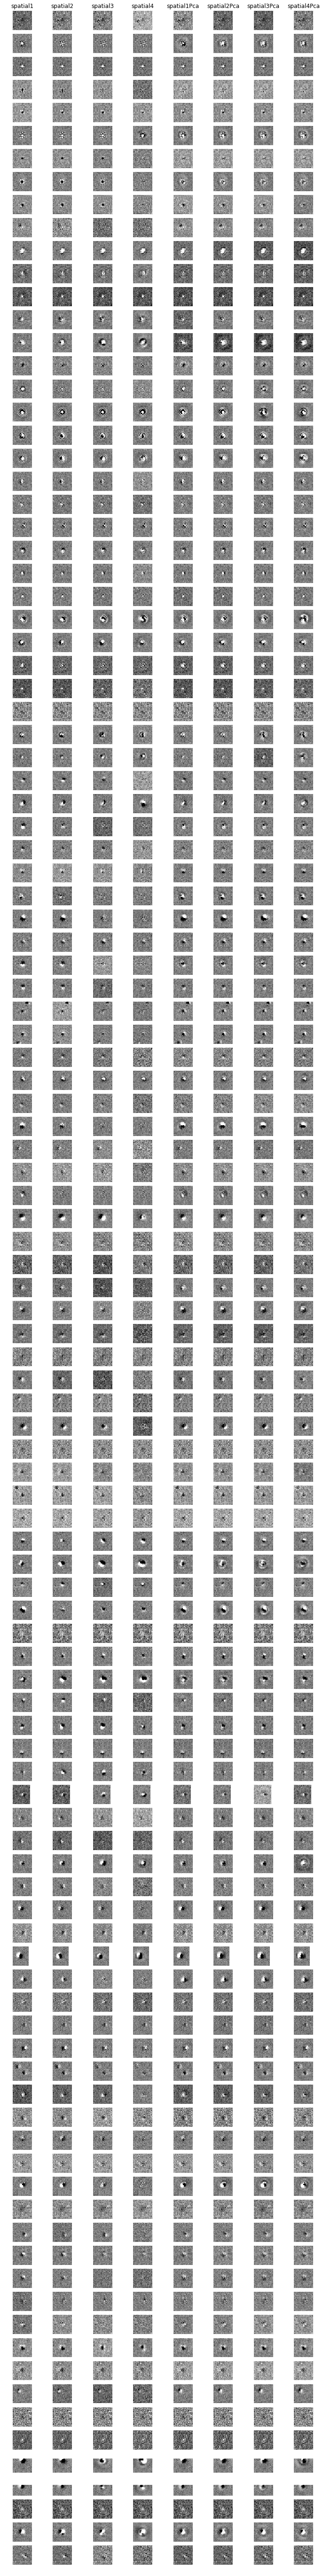

In [25]:
row_len = len(art_remaining)
fig, ax = plt.subplots(row_len, len(config_list), figsize=(12,100))
# fig.subplots_adjust(wspace=0.2)
for i, diaSrc in enumerate(art_remaining):
    if i == row_len:
        break
    visit = str(diaSrc['visit'])
    det = str(diaSrc['detector'])
    key = f'{patch_id}{patch_id}_20_21_' + visit + '_'  + det + '_' + 'i'
    for j, config in enumerate(config_list):
        diff_exp = diffexp_dict[key+'_'+config]
        x = diaSrc['base_NaiveCentroid_x']
        y = diaSrc['base_NaiveCentroid_y']
        diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
        ax[i][j].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
        ax[i][j].axis('off')
        if i == 0:
            ax[i][j].set_title(config.split('_')[1])

#### flux residual

We inject simulated point sources at 20 magnitude.

(-0.06, 0.06)

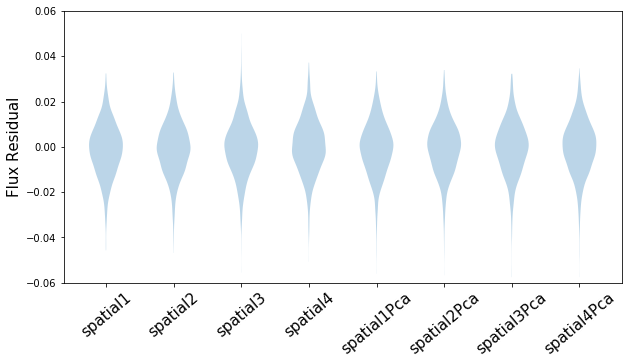

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
ax.violinplot(res_list, showmedians=False, showextrema=False);
ax.set_xticks([1,2,3,4,5,6,7,8])
ax.set_xticklabels(['spatial1', 'spatial2', 'spatial3', 'spatial4',
                    'spatial1Pca', 'spatial2Pca', 'spatial3Pca', 'spatial4Pca'],  rotation=40, size=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_ylabel('Flux Residual', size=15)
ax.set_ylim((-0.06, 0.06))

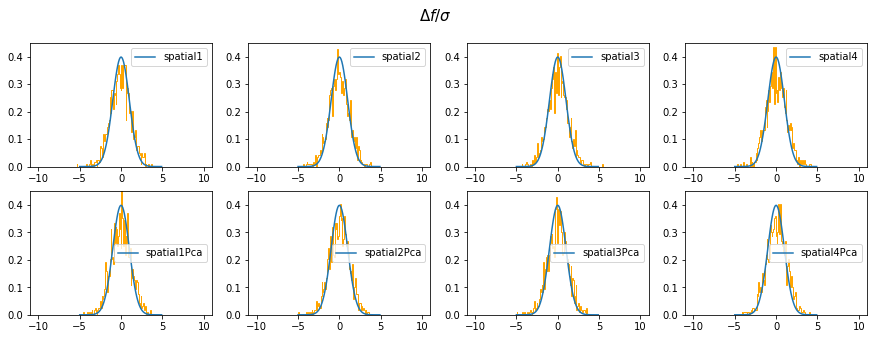

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
ax_ls = ax.flat
bins = np.linspace(-10, 10, 200)
for i, config in enumerate(config_list):
    df = df_list[i]
    ax_ls[i].plot(norm_x, norm_y, label=config.split('_')[1])
    ax_ls[i].hist(df ,density=True, bins=bins,color='orange', histtype='step')
    # ax_ls[i].set_title(f'Flux Pull', size=15)
    # ax_ls[i].set_xlabel('$\Delta f / \sigma$', size=15)
    ax_ls[i].set_ylim((0,0.45))
    ax_ls[i].legend()
plt.suptitle('$\Delta f / \sigma$', size=15);